## Quality assessment (supplementary figure 1)


Unique values in 'Quality assessment':
['Good' 'Moderate' 'Poor']

Plotting data for All Studies:
                            0        0.5          1       Poor   Moderate  \
selection           13.043478  17.391304  69.565217   0.000000   0.000000   
comparability        0.000000  39.130435  60.869565   0.000000   0.000000   
outcome              0.000000  13.043478  86.956522   0.000000   0.000000   
Quality assessment   0.000000   0.000000   0.000000  13.043478  26.086957   

                         Good  
selection            0.000000  
comparability        0.000000  
outcome              0.000000  
Quality assessment  60.869565  


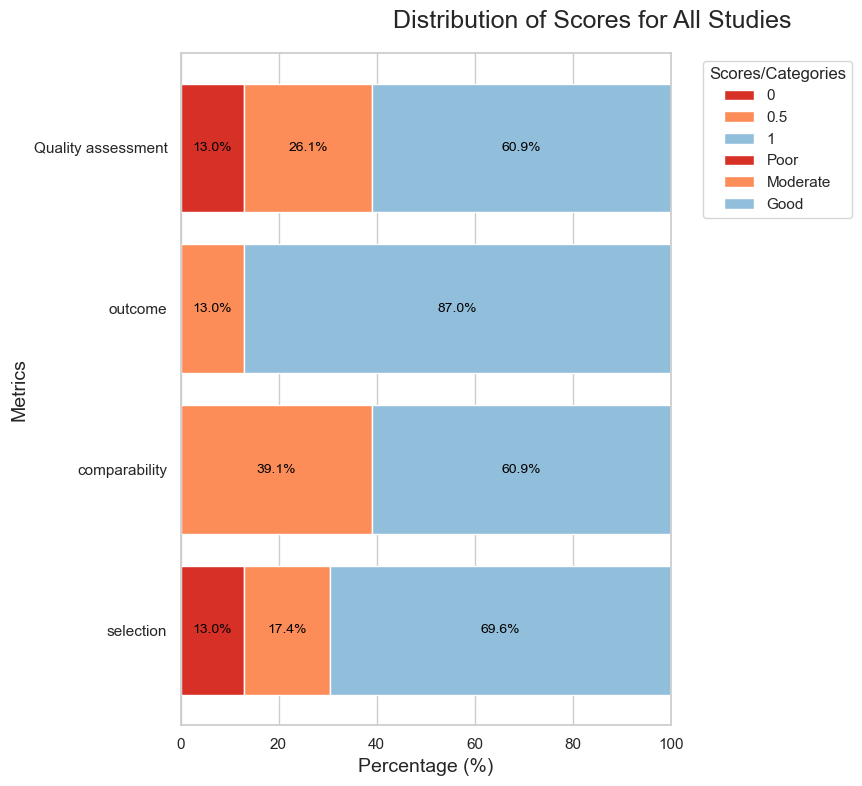


Plotting data for Human Studies:
                            0        0.5          1       Poor   Moderate  \
selection           21.428571  21.428571  57.142857   0.000000   0.000000   
comparability        0.000000  64.285714  35.714286   0.000000   0.000000   
outcome              0.000000  21.428571  78.571429   0.000000   0.000000   
Quality assessment   0.000000   0.000000   0.000000  21.428571  42.857143   

                         Good  
selection            0.000000  
comparability        0.000000  
outcome              0.000000  
Quality assessment  35.714286  


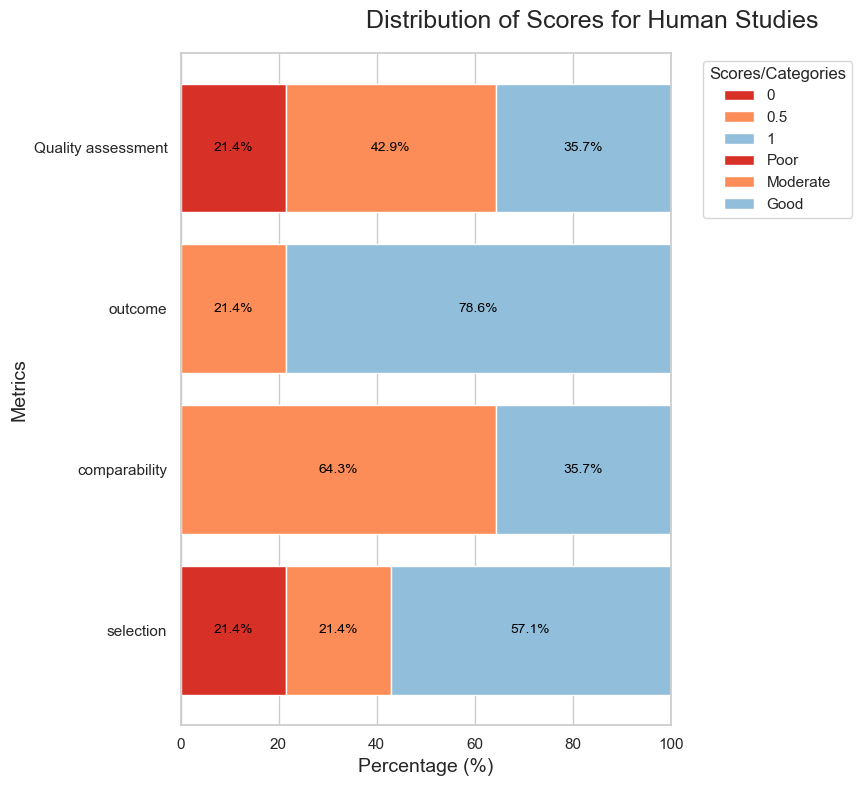


Plotting data for Animal Studies:
                      0        0.5           1  Poor  Moderate   Good
selection           0.0  11.111111   88.888889   0.0       0.0    0.0
comparability       0.0   0.000000  100.000000   0.0       0.0    0.0
outcome             0.0   0.000000  100.000000   0.0       0.0    0.0
Quality assessment  0.0   0.000000    0.000000   0.0       0.0  100.0


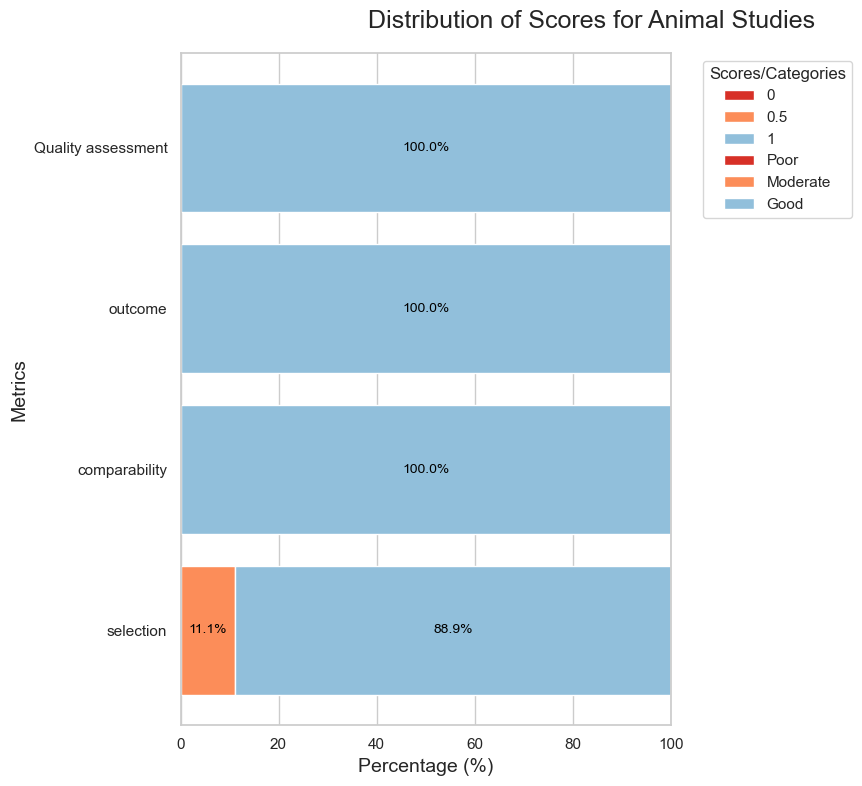

In [65]:
## package needed (python 3.13)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# load screened studies
file_path = 'source_data.xlsx' 
sheet_name = 'assessment'

# just to make sure the file is there
try:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
except FileNotFoundError:
    print(f"The file {file_path} was not found.")
    exit()
except ValueError:
    print(f"The sheet {sheet_name} does not exist in the Excel file.")
    exit()

expected_columns = ['selection', 'comparability', 'outcome', 'Quality assessment', 'subject']
if not all(column in df.columns for column in expected_columns):
    print("The DataFrame does not contain the expected columns.")
    print("Available columns:", df.columns.tolist())
    exit()
df['Quality assessment'] = df['Quality assessment'].astype(str).str.capitalize().str.strip()
print("\nUnique values in 'Quality assessment':")
print(df['Quality assessment'].unique())

# separate human and other animals
groups = {
    'All Studies': df,
    'Human Studies': df[df['subject'].str.lower() == 'human'],
    'Animal Studies': df[df['subject'].str.lower() == 'animal']
}

metrics = {
    'selection': [0, 0.5, 1],
    'comparability': [0, 0.5, 1],
    'outcome': [0, 0.5, 1],
    'Quality assessment': ['Poor', 'Moderate', 'Good']
}

all_categories = set()
for cats in metrics.values():
    all_categories.update(cats)
all_categories = sorted(all_categories, key=lambda x: (isinstance(x, str), x))  # Sort numbers first, then strings
all_categories = [0, 0.5, 1, 'Poor', 'Moderate', 'Good']

# color palette
colors = {
    0: '#d73027',          # Red
    0.5: '#fc8d59',        # Orange 
    1: '#91bfdb',          # Light blue
    'Poor': '#d73027',     # Ddark red
    'Moderate': '#fc8d59', # Light orange
    'Good': '#91bfdb'      # green
}

def prepare_plot_data(data, metrics, all_categories):
    plot_data = pd.DataFrame(0, index=metrics.keys(), columns=all_categories, dtype=float)

    for metric, categories in metrics.items():
        counts = data[metric].value_counts().reindex(categories).fillna(0)
        total = counts.sum()
        if total > 0:
            percentage = (counts / total) * 100
        else:
            percentage = counts  # do not divide     
        for category in categories:
            plot_data.at[metric, category] = percentage.get(category, 0)
    
    return plot_data

def plot_stacked_horizontal_bars(group_name, plot_data, all_categories, colors):
    categories = list(plot_data.index)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(f'Distribution of Scores for {group_name}', fontsize=18)
    left = [0] * len(categories)
    
    # stacking plot
    for category in all_categories:
        percentages = plot_data[category].values
        color = colors.get(category, '#333333')  # gray
        ax.barh(categories, percentages, left=left, color=color, edgecolor='white', label=category)
        
        left = [i + j for i, j in zip(left, percentages)]
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Scores/Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Percentage (%)', fontsize=14)
    ax.set_ylabel('Metrics', fontsize=14)
    
    for i, metric in enumerate(categories):
        cumulative = 0
        for category in all_categories:
            value = plot_data.at[metric, category]
            if value > 0:
                ax.text(cumulative + value / 2, i, f'{value:.1f}%', va='center', ha='center', color='black', fontsize=10)
                cumulative += value
    
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()
    return fig

# Plot for each group
for group_name, group_data in groups.items():
    if group_data.empty:
        print(f"No data available for {group_name}.")
    else:
        # Prepare plot data
        plot_data = prepare_plot_data(group_data, metrics, all_categories)
        print(f"\nPlotting data for {group_name}:")
        print(plot_data)
        # Plot
        fig = plot_stacked_horizontal_bars(group_name, plot_data, all_categories, colors)
        # the following is for saving the figure in local
        file_name = f"{group_name.replace(' ', '_')}_distribution.pdf" 
        fig.savefig(file_name)

## HIFUS - effect size (MRgFUS)
It is for getting statistics (Result section: Efficacy of FUS for treating depression) but not for generating figure

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

file_path = 'source_data.xlsx' 
sheet_name = 'MRgFUS'
def calculate_reduction(data, baseline_column, follow_up_column):
    return ((data[baseline_column] - data[follow_up_column]) / data[baseline_column]) * 100

df = pd.read_excel(file_path, sheet_name=sheet_name)
pivot_data = df.pivot(index='id', columns='follow-up', values='HAMD').reset_index()

pivot_data['reduction_6_month'] = calculate_reduction(pivot_data, 'baseline', '6_month')
pivot_data['reduction_12_month'] = calculate_reduction(pivot_data, 'baseline', '12_month')
pivot_data['reduction_longterm'] = calculate_reduction(pivot_data, 'baseline', 'longterm')

#  means and standard errors
mean_se = {
    'Time_Point': ['6_month', '12_month', 'longterm'],
    'Mean_Reduction': [
        pivot_data['reduction_6_month'].mean(),
        pivot_data['reduction_12_month'].mean(),
        pivot_data['reduction_longterm'].mean()
    ],
    'SE': [
        pivot_data['reduction_6_month'].std() / np.sqrt(pivot_data['reduction_6_month'].count()),
        pivot_data['reduction_12_month'].std() / np.sqrt(pivot_data['reduction_12_month'].count()),
        pivot_data['reduction_longterm'].std() / np.sqrt(pivot_data['reduction_longterm'].count())
    ]
}
mean_se_df = pd.DataFrame(mean_se)
print(mean_se_df)

# test to see reduction is significant
results = {}
for time_point in ['6_month', '12_month', 'longterm']:
    if time_point in pivot_data.columns:
        valid_pairs = pivot_data[['baseline', time_point]].dropna()
        t_stat, p_value = ttest_rel(pivot_data['baseline'], pivot_data[time_point], nan_policy='omit')
        effect_size = (pivot_data['baseline'].mean() - pivot_data[time_point].mean()) / pivot_data['baseline'].std()
        n = len(valid_pairs)
        results[time_point] = {'t_stat': t_stat, 'p_value': p_value, 'effect_size': effect_size, 'n':n}

stat_results_df = pd.DataFrame.from_dict(results, orient='index', columns=['t_stat', 'p_value', 'effect_size', 'n'])
stat_results_df

  Time_Point  Mean_Reduction         SE
0    6_month       28.127798  11.238585
1   12_month       22.984531  12.654555
2   longterm       39.371418  19.383351


,t_stat,p_value,effect_size,n
6_month,2.520402,0.026889,1.920823,13
12_month,1.986069,0.070352,1.663394,13
longterm,2.071072,0.093113,2.802026,6


## Figure 4 - latest follow up - ITT estimates

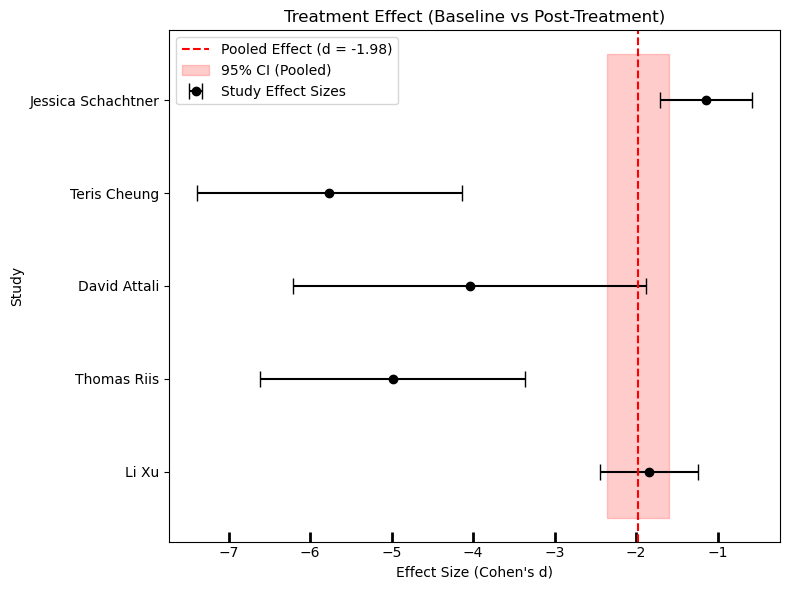

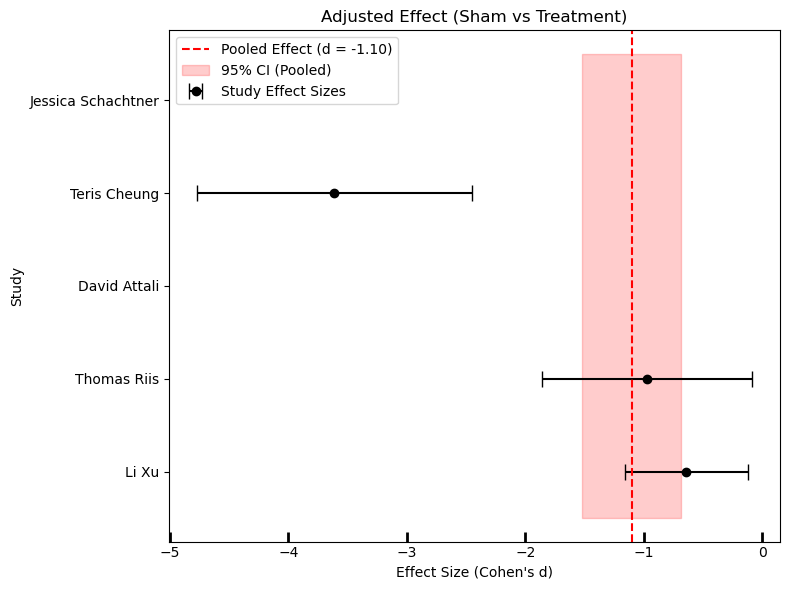

-1.9794187593112629 -2.3610029282414278 -1.597834590381098
-1.1004091726970262 -1.5182976741652072 -0.6825206712288452
Within-treatment: Q=46.31, df=4, I²=91.4%
Adjusted: Q=21.05, df=4, I²=81.0%


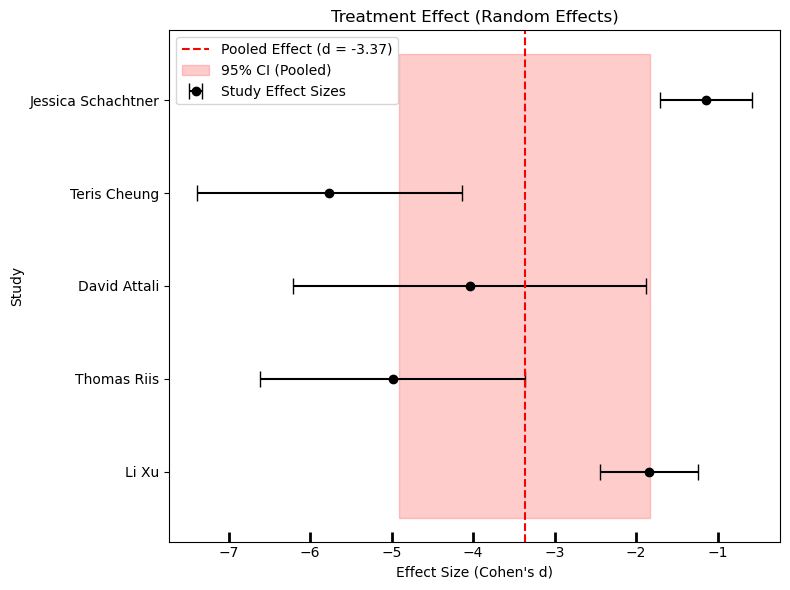

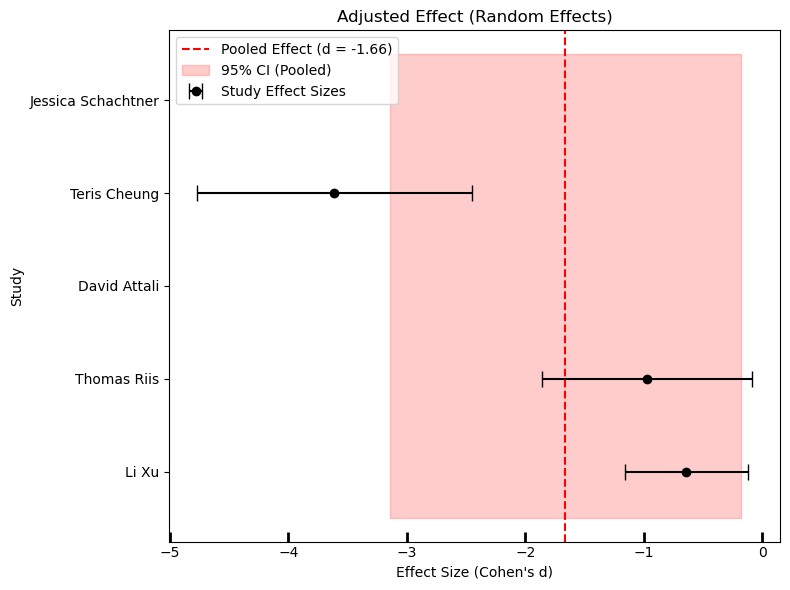

Random-Effects: Treatment vs Baseline
Pooled d = -3.369 [95% CI: -4.905, -1.832], τ² = 2.5753, Q = 46.31, df = 4

Random-Effects: Adjusted Sham vs Treatment
Pooled d = -1.662 [95% CI: -3.142, -0.182], τ² = 1.5093, Q = 21.05, df = 4


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# pooled Cohen's d
def pooled_cohens_d_with_ci(effects, variances):
    weights = 1 / variances
    pooled_d = np.sum(weights * effects) / np.sum(weights)
    pooled_var = 1 / np.sum(weights)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    return pooled_d, ci_lower, ci_upper, pooled_var
# Data (add second search data)
data = {
    "id": [1, 2, 3, 4, 5],
    "author": ["Li Xu", "Jooyoung Oh", "Thomas Riis", "David Attali", "Teris Cheung"],
    "mean_baseline_control": [43.16, 29.2, 10.8, np.nan, 21.6],
    "sem_baseline_control": [4.99, 2.396, 0.727, np.nan, 2.2463],  # SEM values

    "mean_baseline_treatment": [42.8, 28.5, 11.4, 37.2, 25.73],
    "sem_baseline_treatment": [4.34, 2.5327, 0.635, 3.08577,2.439979],  # SEM values
    "n_treatment": [30, 11, 12, 5, 15],
    "mean_post_control": [40.34, 24.8, 7.2, np.nan, 19.8],
    "sem_post_control": [4.33, 2.684679, 1.486, np.nan, 1.77899],  # SEM values
    "n_control": [30, 12, 10, np.nan, 15],
    "mean_post_treatment": [36.2, 14.8, 6.3, 22.8, 13.2],
    "sem_post_treatment": [2.6, 2.17, 1.299, 3.98, 1.869],  # SEM values

}
df = pd.DataFrame(data)


df["change_treatment"] = df["mean_post_treatment"] - df["mean_baseline_treatment"]
df["change_control"] = df["mean_post_control"] - df["mean_baseline_control"]


df["se_change_treatment"] = np.sqrt(df["sem_post_treatment"]**2 + df["sem_baseline_treatment"]**2)
df["se_change_control"] = np.sqrt(df["sem_post_control"]**2 + df["sem_baseline_control"]**2)

# in this study, the author report the estimated slope as -4.2, with three timepts, baseline, wk1, wk3, the 95CI is [-5.85, -2.62],
# with that the SE of the slope estimate is (5.85-2.62) / 2 / 1.96 = 0.824, we double the SE for wk3 (latest follow up)

def calculate_cohens_d_with_variance(mean1, mean2, sem1, sem2, n1, n2):
    sd_pooled = np.sqrt(((n1 - 1) * (sem1**2) + (n2 - 1) * (sem2**2)) / (n1 + n2 - 2))
    d = (mean2 - mean1) / sd_pooled
    var_d = (n1 + n2) / (n1 * n2) + (d**2) / (2 * (n1 + n2))
    se_d = np.sqrt(var_d)
    ci_lower = d - 1.96 * se_d
    ci_upper = d + 1.96 * se_d
    return d, ci_lower, ci_upper, var_d


# Cohen's d and variances for treatment effect (within-subject), there is alternative (still under debates) to calculate d_rm or d_av; 
# d_rm = delta/sd_diff, with sd_diff = sqrt(sd1^2 + sd2^2 - 2r *sd1*sd2)), and with var_d = (2*(1-r))/n +drm^2/2/n
#  with d_av = delta/((sd1+sd2)/2), se_av = se_diff / ((sd1+sd2)/2), se_diff is based on sd_diff
# for id_5, we know delta and se_diff, so we are able to estimate d_rm
df["cohens_d_treatment"], df["ci_lower_treatment"], df["ci_upper_treatment"], df["variance_treatment"] = zip(
    *df.apply(
        lambda row: calculate_cohens_d_with_variance(
            row["mean_baseline_treatment"],
            row["mean_post_treatment"],
            row["sem_baseline_treatment"],
            row["sem_post_treatment"],
            row["n_treatment"],
            row["n_treatment"]
        ),
        axis=1
    )
)

# compare btw treatment and sham
df["cohens_d_adjusted"], df["ci_lower_adjusted"], df["ci_upper_adjusted"], df["variance_adjusted"] = zip(
    *df.apply(
        lambda row: calculate_cohens_d_with_variance(
            -row["mean_baseline_control"] + row["mean_post_control"],
            -row["mean_baseline_treatment"] + row["mean_post_treatment"],
            row["se_change_control"],
            row["se_change_treatment"],
            row["n_control"],
            row["n_treatment"]
        ),
        axis=1
    )
)

id5 = {
    "id": 6,
    "author": "Jessica Schachtner",
    "mean_baseline_control": np.nan,
    "sem_baseline_control": np.nan,
    "mean_baseline_treatment": np.nan,
    "sem_baseline_treatment": np.nan,
    "mean_post_control": np.nan,
    "sem_post_control": np.nan,
    "mean_post_treatment": np.nan,
    "sem_post_treatment": np.nan,
    "change_treatment": -4.2 * 2,
    "se_change_treatment": 2 * (5.85 - 2.62) / (2 * 1.96),  # from CI width
    "n_treatment": 20,
    "n_control": np.nan,
    
}
# formula with r=0.5 (see https://www.campbellcollaboration.org/calculator/equations#means-and-standard-errors)
id5['cohens_d_treatment'] = id5['change_treatment'] / (id5['se_change_treatment'] * np.sqrt(id5['n_treatment']))
# the denominator is sd_diff
id5['variance_treatment'] = (1) / (id5['n_treatment'] ) +\
    (id5['cohens_d_treatment'] **2) / (2 * id5['n_treatment'] )

id5['ci_lower_treatment'] = id5['cohens_d_treatment']  - 1.96 * np.sqrt(id5['variance_treatment'])
id5['ci_upper_treatment'] = id5['cohens_d_treatment']  + 1.96 * np.sqrt(id5['variance_treatment'])

df = pd.concat([df, pd.DataFrame([id5])], ignore_index=True)
# remove Oh, because 3 subject drop out
df = df[df["id"] != 2].reset_index(drop=True)

pooled_treatment, ci_lower_treatment, ci_upper_treatment, var_treatment = pooled_cohens_d_with_ci(
    df["cohens_d_treatment"], df["variance_treatment"]
)
pooled_adjusted, ci_lower_adjusted, ci_upper_adjusted, var_adjusted = pooled_cohens_d_with_ci(
    df["cohens_d_adjusted"], df["variance_adjusted"]
)

#  forest plot function
def refined_forest_plot(data, effect_col, ci_lower_col, ci_upper_col, pooled_d, pooled_ci_lower, pooled_ci_upper, title, filename):
    plt.figure(figsize=(8, 6))
    
    y_pos = range(len(data))
    plt.errorbar(data[effect_col], y_pos, 
                 xerr=[data[effect_col] - data[ci_lower_col], data[ci_upper_col] - data[effect_col]], 
                 fmt='o', color='black', label='Study Effect Sizes', capsize=6)
    
    plt.axvline(pooled_d, color='red', linestyle='--', label=f'Pooled Effect (d = {pooled_d:.2f})')
    plt.fill_betweenx(
        [-0.5, len(data) - 0.5],
        pooled_ci_lower, pooled_ci_upper,
        color='red', alpha=0.2, label='95% CI (Pooled)'
    )
    ax=plt.gca()
    ax.tick_params(axis='x', which='both', length=7, width=2, direction='in')  
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(True)
        tick.tick1line.set_markersize(7)
        tick.tick1line.set_markeredgewidth(2)
    plt.yticks(y_pos, data["author"])
    # plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("Study")
    plt.legend(loc="upper left")
    # plt.grid(axis="x", linestyle="--", alpha=0.6)
    # for adding the figure to the paper
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()

#  effect within the treatment group
refined_forest_plot(
    df,
    "cohens_d_treatment",
    "ci_lower_treatment",
    "ci_upper_treatment",
    pooled_treatment,
    ci_lower_treatment,
    ci_upper_treatment,
    "Treatment Effect (Baseline vs Post-Treatment)",
    "forest_plot_treatment_effect_human_lifus.pdf"
)

# btw treatment and sham 
refined_forest_plot(
    df,
    "cohens_d_adjusted",
    "ci_lower_adjusted",
    "ci_upper_adjusted",
    pooled_adjusted,
    ci_lower_adjusted,
    ci_upper_adjusted,
    "Adjusted Effect (Sham vs Treatment)",
    "forest_plot_adjusted_effect_human_lifus.pdf"
)

print(pooled_treatment,
    ci_lower_treatment,
    ci_upper_treatment,)

print( pooled_adjusted,
    ci_lower_adjusted,
    ci_upper_adjusted,)

def calculate_heterogeneity(effects, variances):
    weights = 1 / variances
    weighted_mean = np.sum(weights * effects) / np.sum(weights)
    Q = np.sum(weights * (effects - weighted_mean)**2)
    df = len(effects) - 1
    I2 = max(0, (Q - df) / Q) * 100 if Q > df else 0
    return Q, df, I2

# Heterogeneity for within-treatment effect
Q_treat, df_treat, I2_treat = calculate_heterogeneity(df["cohens_d_treatment"], df["variance_treatment"])
print(f"Within-treatment: Q={Q_treat:.2f}, df={df_treat}, I²={I2_treat:.1f}%")

# Heterogeneity for sham-adjusted effect
Q_adj, df_adj, I2_adj = calculate_heterogeneity(df["cohens_d_adjusted"], df["variance_adjusted"])
print(f"Adjusted: Q={Q_adj:.2f}, df={df_adj}, I²={I2_adj:.1f}%")

# random-effect meta analysis (DerSimonian–Laird method)
def random_effects_meta(effects, variances):
    k = len(effects)
    weights_fixed = 1 / variances
    pooled_fixed = np.sum(weights_fixed * effects) / np.sum(weights_fixed)
    Q = np.sum(weights_fixed * (effects - pooled_fixed) ** 2)
    df = k - 1
    tau2 = max(0, (Q - df) / (np.sum(weights_fixed) - np.sum(weights_fixed**2) / np.sum(weights_fixed)))
    
    weights_random = 1 / (variances + tau2)
    pooled_d = np.sum(weights_random * effects) / np.sum(weights_random)
    pooled_var = 1 / np.sum(weights_random)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    
    return pooled_d, ci_lower, ci_upper, tau2, Q, df

rand_d_treat, rand_ci_lo_treat, rand_ci_hi_treat, tau2_treat, Q_treat, df_treat = random_effects_meta(
    df["cohens_d_treatment"], df["variance_treatment"]
)

# Random-effects: treatment vs sham
rand_d_adj, rand_ci_lo_adj, rand_ci_hi_adj, tau2_adj, Q_adj, df_adj = random_effects_meta(
    df["cohens_d_adjusted"], df["variance_adjusted"]
)
refined_forest_plot(
    df,
    "cohens_d_treatment",
    "ci_lower_treatment",
    "ci_upper_treatment",
    rand_d_treat,
    rand_ci_lo_treat,
    rand_ci_hi_treat,
    "Treatment Effect (Random Effects)",
    "forest_plot_treatment_effect_human_lifus_random_effect.pdf"
)

# Random-effects forest plot: adjusted effect
refined_forest_plot(
    df,
    "cohens_d_adjusted",
    "ci_lower_adjusted",
    "ci_upper_adjusted",
    rand_d_adj,
    rand_ci_lo_adj,
    rand_ci_hi_adj,
    "Adjusted Effect (Random Effects)",
    "forest_plot_adjusted_effect_human_lifus_random_effect.pdf"
)
print("Random-Effects: Treatment vs Baseline")
print(f"Pooled d = {rand_d_treat:.3f} [95% CI: {rand_ci_lo_treat:.3f}, {rand_ci_hi_treat:.3f}], τ² = {tau2_treat:.4f}, Q = {Q_treat:.2f}, df = {df_treat}")

print("\nRandom-Effects: Adjusted Sham vs Treatment")
print(f"Pooled d = {rand_d_adj:.3f} [95% CI: {rand_ci_lo_adj:.3f}, {rand_ci_hi_adj:.3f}], τ² = {tau2_adj:.4f}, Q = {Q_adj:.2f}, df = {df_adj}")

## Figure 4 - figure supplement - sensitivity analysis (based on per-protocol samples)

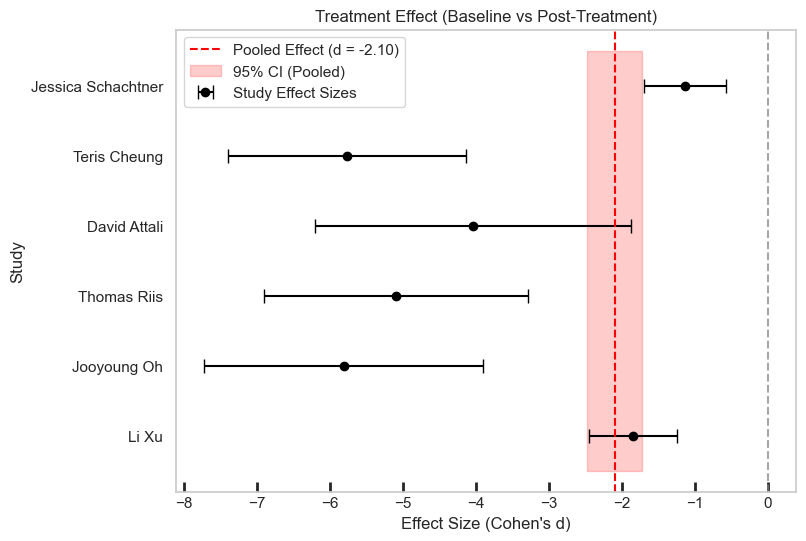

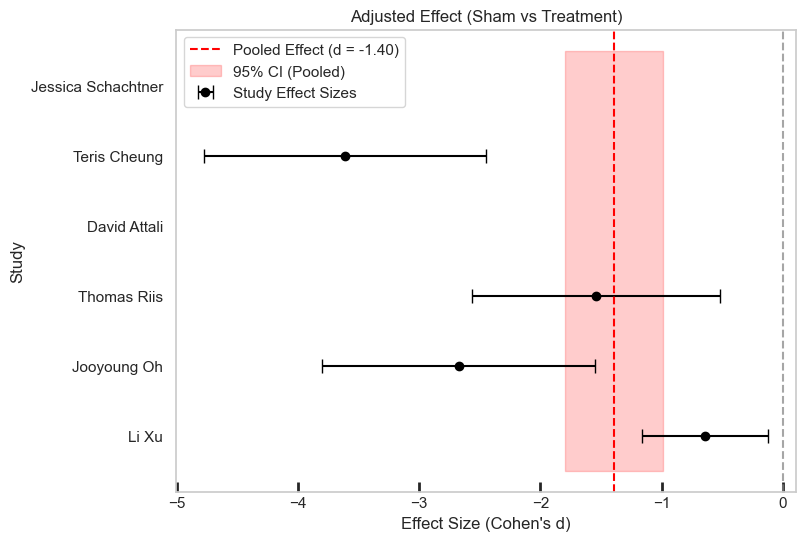

-2.101458212393617 -2.4775753803628224 -1.7253410444244115
-1.3953577177596592 -1.7971221936271418 -0.9935932418921767
Within-treatment: Q=59.58, df=5, I²=91.6%
Adjusted: Q=27.14, df=5, I²=81.6%


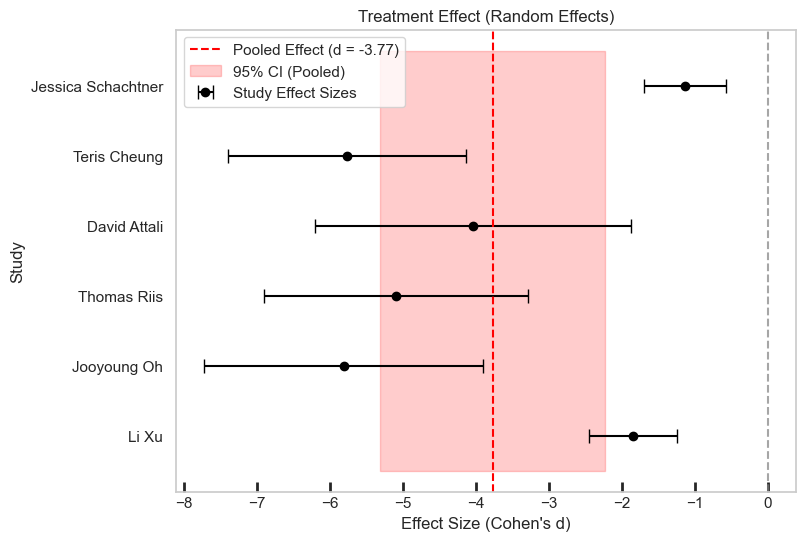

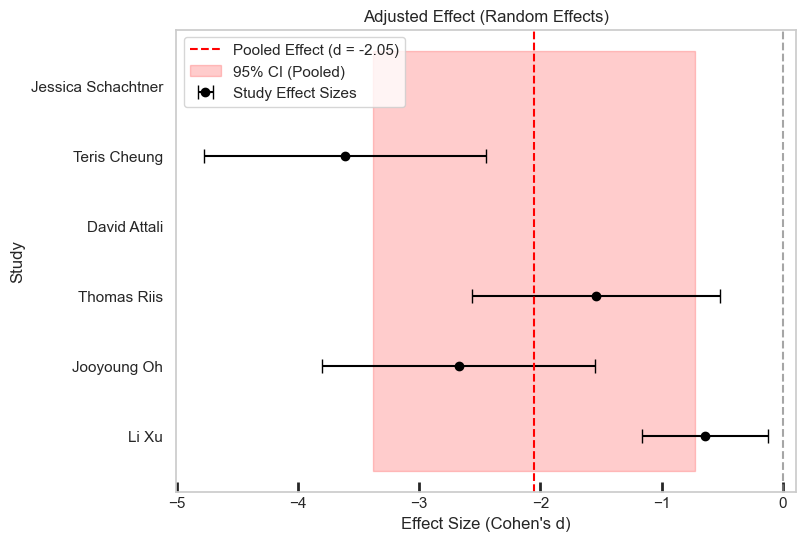

Random-Effects: Treatment vs Baseline
Pooled d = -3.771 [95% CI: -5.315, -2.228], τ² = 3.1239, Q = 59.58, df = 5

Random-Effects: Adjusted Sham vs Treatment
Pooled d = -2.055 [95% CI: -3.382, -0.727], τ² = 1.5856, Q = 27.14, df = 5


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# pooled Cohen's d
def pooled_cohens_d_with_ci(effects, variances):
    weights = 1 / variances
    pooled_d = np.sum(weights * effects) / np.sum(weights)
    pooled_var = 1 / np.sum(weights)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    return pooled_d, ci_lower, ci_upper, pooled_var
# Data
data = {
    "id": [1, 2, 3, 4, 5],
    "author": ["Li Xu", "Jooyoung Oh", "Thomas Riis", "David Attali", "Teris Cheung"],
    "mean_baseline_control": [43.16, 29.2, 10.7, np.nan, 21.6],
    "sem_baseline_control": [4.99, 2.396, 0.9, np.nan, 2.2463],  # SEM values

    "mean_baseline_treatment": [42.8, 28.5, 11.9, 37.2, 25.73],
    "sem_baseline_treatment": [4.34, 2.5327, 0.5376, 3.08577, 2.439979],  # SEM values
    "n_treatment": [30, 11, 10, 5, 15],
    "mean_post_control": [40.34, 24.8, 7.6, np.nan, 19.8],
    "sem_post_control": [4.33, 2.684679, 1.6667, np.nan, 1.77899],  # SEM values
    "n_control": [30, 12, 9, np.nan, 15],
    "mean_post_treatment": [36.2, 14.8, 6.1, 22.8, 13.2],
    "sem_post_treatment": [2.6, 2.17, 1.5179, 3.98, 1.869],  # SEM values

}


df = pd.DataFrame(data)


df["change_treatment"] = df["mean_post_treatment"] - df["mean_baseline_treatment"]
df["change_control"] = df["mean_post_control"] - df["mean_baseline_control"]


df["se_change_treatment"] = np.sqrt(df["sem_post_treatment"]**2 + df["sem_baseline_treatment"]**2)
df["se_change_control"] = np.sqrt(df["sem_post_control"]**2 + df["sem_baseline_control"]**2)
def calculate_cohens_d_with_variance(mean1, mean2, sem1, sem2, n1, n2):
    sd_pooled = np.sqrt(((n1 - 1) * (sem1**2) + (n2 - 1) * (sem2**2)) / (n1 + n2 - 2))
    d = (mean2 - mean1) / sd_pooled
    var_d = (n1 + n2) / (n1 * n2) + (d**2) / (2 * (n1 + n2))
    se_d = np.sqrt(var_d)
    ci_lower = d - 1.96 * se_d
    ci_upper = d + 1.96 * se_d
    return d, ci_lower, ci_upper, var_d

# Cohen's d and variances for treatment effect
df["cohens_d_treatment"], df["ci_lower_treatment"], df["ci_upper_treatment"], df["variance_treatment"] = zip(
    *df.apply(
        lambda row: calculate_cohens_d_with_variance(
            row["mean_baseline_treatment"],
            row["mean_post_treatment"],
            row["sem_baseline_treatment"],
            row["sem_post_treatment"],
            row["n_treatment"],
            row["n_treatment"]
        ),
        axis=1
    )
)

# compare btw treatment and sham
df["cohens_d_adjusted"], df["ci_lower_adjusted"], df["ci_upper_adjusted"], df["variance_adjusted"] = zip(
    *df.apply(
        lambda row: calculate_cohens_d_with_variance(
            -row["mean_baseline_control"] + row["mean_post_control"],
            -row["mean_baseline_treatment"] + row["mean_post_treatment"],
            row["se_change_control"],
            row["se_change_treatment"],
            row["n_control"],
            row["n_treatment"]
        ),
        axis=1
    )
)


id5 = {
    "id": 6,
    "author": "Jessica Schachtner",
    "mean_baseline_control": np.nan,
    "sem_baseline_control": np.nan,
    "mean_baseline_treatment": np.nan,
    "sem_baseline_treatment": np.nan,
    "mean_post_control": np.nan,
    "sem_post_control": np.nan,
    "mean_post_treatment": np.nan,
    "sem_post_treatment": np.nan,
    "change_treatment": -4.2 * 2,
    "se_change_treatment": 2 * (5.85 - 2.62) / (2 * 1.96),  # from CI width
    "n_treatment": 20,
    "n_control": np.nan,
    
}
# formula with r=0.5 (see https://www.campbellcollaboration.org/calculator/equations#means-and-standard-errors)
id5['cohens_d_treatment'] = id5['change_treatment'] / (id5['se_change_treatment'] * np.sqrt(id5['n_treatment']))
# the denominator is sd_diff
id5['variance_treatment'] = (1) / (id5['n_treatment'] ) +\
    (id5['cohens_d_treatment'] **2) / (2 * id5['n_treatment'] )

id5['ci_lower_treatment'] = id5['cohens_d_treatment']  - 1.96 * np.sqrt(id5['variance_treatment'])
id5['ci_upper_treatment'] = id5['cohens_d_treatment']  + 1.96 * np.sqrt(id5['variance_treatment'])

df = pd.concat([df, pd.DataFrame([id5])], ignore_index=True)



pooled_treatment, ci_lower_treatment, ci_upper_treatment, var_treatment = pooled_cohens_d_with_ci(
    df["cohens_d_treatment"], df["variance_treatment"]
)
pooled_adjusted, ci_lower_adjusted, ci_upper_adjusted, var_adjusted = pooled_cohens_d_with_ci(
    df["cohens_d_adjusted"], df["variance_adjusted"]
)

#  forest plot function
def refined_forest_plot(data, effect_col, ci_lower_col, ci_upper_col, pooled_d, pooled_ci_lower, pooled_ci_upper, title, filename):
    plt.figure(figsize=(8, 6))
    
    y_pos = range(len(data))
    plt.errorbar(data[effect_col], y_pos, 
                 xerr=[data[effect_col] - data[ci_lower_col], data[ci_upper_col] - data[effect_col]], 
                 fmt='o', color='black', label='Study Effect Sizes', capsize=5)
    
    plt.axvline(pooled_d, color='red', linestyle='--', label=f'Pooled Effect (d = {pooled_d:.2f})')
    plt.fill_betweenx(
        [-0.5, len(data) - 0.5],
        pooled_ci_lower, pooled_ci_upper,
        color='red', alpha=0.2, label='95% CI (Pooled)'
    )
    
    ax=plt.gca()
    ax.tick_params(axis='x', which='both', length=7, width=2, direction='in')  
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(True)
        tick.tick1line.set_markersize(7)
        tick.tick1line.set_markeredgewidth(2)
    plt.yticks(y_pos, data["author"])
    plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("Study")
    plt.legend(loc="upper left")
    plt.grid(False)
    # for adding the figure to the paper
    plt.savefig(filename)
    plt.show()

#  effect within the treatment group
refined_forest_plot(
    df,
    "cohens_d_treatment",
    "ci_lower_treatment",
    "ci_upper_treatment",
    pooled_treatment,
    ci_lower_treatment,
    ci_upper_treatment,
    "Treatment Effect (Baseline vs Post-Treatment)",
    "forest_plot_treatment_effect_human_lifus_pp_estimate.pdf"
)

# btw treatment and sham 
refined_forest_plot(
    df,
    "cohens_d_adjusted",
    "ci_lower_adjusted",
    "ci_upper_adjusted",
    pooled_adjusted,
    ci_lower_adjusted,
    ci_upper_adjusted,
    "Adjusted Effect (Sham vs Treatment)",
    "forest_plot_adjusted_effect_human_lifus_pp_estimate.pdf"
)

print(pooled_treatment,
    ci_lower_treatment,
    ci_upper_treatment,)

print( pooled_adjusted,
    ci_lower_adjusted,
    ci_upper_adjusted,)

def calculate_heterogeneity(effects, variances):
    weights = 1 / variances
    weighted_mean = np.sum(weights * effects) / np.sum(weights)
    Q = np.sum(weights * (effects - weighted_mean)**2)
    df = len(effects) - 1
    I2 = max(0, (Q - df) / Q) * 100 if Q > df else 0
    return Q, df, I2

# Heterogeneity for within-treatment effect
Q_treat, df_treat, I2_treat = calculate_heterogeneity(df["cohens_d_treatment"], df["variance_treatment"])
print(f"Within-treatment: Q={Q_treat:.2f}, df={df_treat}, I²={I2_treat:.1f}%")

# Heterogeneity for sham-adjusted effect
Q_adj, df_adj, I2_adj = calculate_heterogeneity(df["cohens_d_adjusted"], df["variance_adjusted"])
print(f"Adjusted: Q={Q_adj:.2f}, df={df_adj}, I²={I2_adj:.1f}%")

## random effect meta analysis
rand_d_treat, rand_ci_lo_treat, rand_ci_hi_treat, tau2_treat, Q_treat, df_treat = random_effects_meta(
    df["cohens_d_treatment"], df["variance_treatment"]
)

# Random-effects: treatment vs sham
rand_d_adj, rand_ci_lo_adj, rand_ci_hi_adj, tau2_adj, Q_adj, df_adj = random_effects_meta(
    df["cohens_d_adjusted"], df["variance_adjusted"]
)
refined_forest_plot(
    df,
    "cohens_d_treatment",
    "ci_lower_treatment",
    "ci_upper_treatment",
    rand_d_treat,
    rand_ci_lo_treat,
    rand_ci_hi_treat,
    "Treatment Effect (Random Effects)",
    "forest_plot_treatment_effect_human_lifus_pp_estimate_random_effect.pdf"
)

# Random-effects forest plot: adjusted effect
refined_forest_plot(
    df,
    "cohens_d_adjusted",
    "ci_lower_adjusted",
    "ci_upper_adjusted",
    rand_d_adj,
    rand_ci_lo_adj,
    rand_ci_hi_adj,
    "Adjusted Effect (Random Effects)",
    "forest_plot_adjusted_effect_human_lifus_pp_estimate_random_effect.pdf"
)
print("Random-Effects: Treatment vs Baseline")
print(f"Pooled d = {rand_d_treat:.3f} [95% CI: {rand_ci_lo_treat:.3f}, {rand_ci_hi_treat:.3f}], τ² = {tau2_treat:.4f}, Q = {Q_treat:.2f}, df = {df_treat}")

print("\nRandom-Effects: Adjusted Sham vs Treatment")
print(f"Pooled d = {rand_d_adj:.3f} [95% CI: {rand_ci_lo_adj:.3f}, {rand_ci_hi_adj:.3f}], τ² = {tau2_adj:.4f}, Q = {Q_adj:.2f}, df = {df_adj}")

## Figure 3 - rodent studies (synthesized effect)
1. spi
2. fst
3. tst

study 4 estimation: {'eta_squared': 0.23296544083180637, 'cohens_f': np.float64(0.5511099910382883), 'var_f': np.float64(0.015709770114942526), 'cohens_d': np.float64(1.2727340067161919), 'var_d': np.float64(0.015709770114942526)}
study 5 estimation: {'eta_squared': 0.324515379056835, 'cohens_f': np.float64(0.6931223590760601), 'var_f': np.float64(0.04367441860465116), 'cohens_d': np.float64(1.697796109050488), 'var_d': np.float64(0.04367441860465116)}
{'pooled_d': np.float64(1.329732385796099), '95%_CI': (np.float64(1.1180921378319235), np.float64(1.5413726337602744)), 'heterogeneity_I2': np.float64(62.4608011598411)}


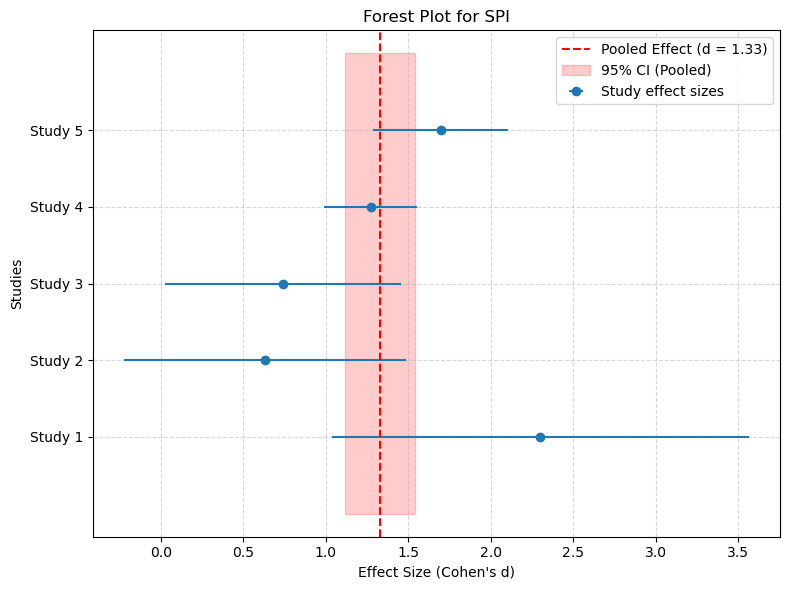

pooled d random effect 1.2884932707560761
pooled d CI random effect [ 0.8642816371711579 , 1.7127049043409943 ]


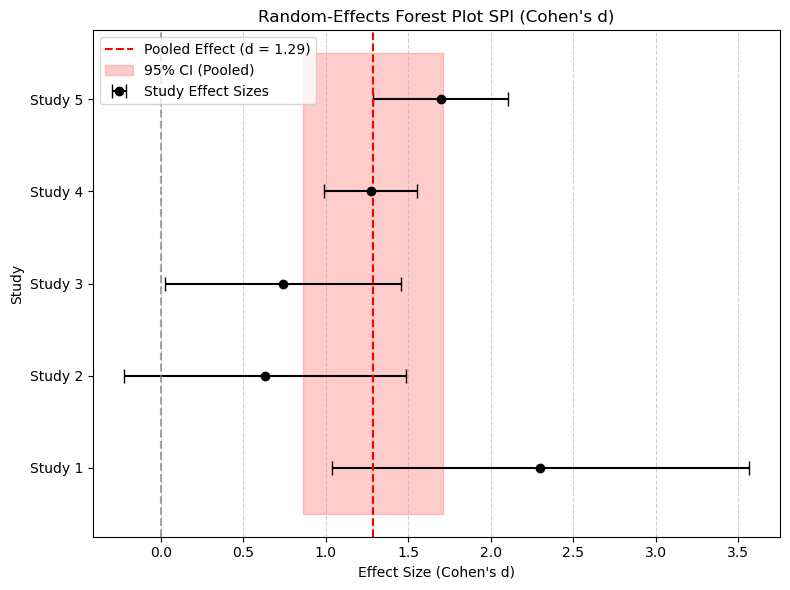

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
# get data from the source file
# from 1 to 5
# Canwen Wu
# Yiyue Zhu
# Daqu Zhang
# Rachael A. Herlihy
# Ling wang
data = [
    {"study": "Study 1", "mean_control": 55.61, "sem_control": 3.29, "n_control": 8,
     "mean_intervention": 77.03, "sem_intervention": 3.29, "n_intervention": 8},
    {"study": "Study 2", "mean_control": 63.57, "sem_control": 4.66, "n_control": 11,
     "mean_intervention": 72.11, "sem_intervention": 3.37, "n_intervention": 11},
    {"study": "Study 3", "mean_control": 72.8, "sem_control": 7.2, "n_control": 16,
     "mean_intervention": 88.8, "sem_intervention": 2.5, "n_intervention": 16},
    {"study": "Study 4", "cohens_f": 0.5511, "k_groups": 4,
    "F_stat":5.467, "total_sample_size":58, "df_effect":3, "df_error":54},
    {"study": "Study 5", "cohens_f": 0.324515379056835,  "k_groups": 3,
     "F_stat":10.329, "total_sample_size":44, "df_effect":2, "df_error":43},
]

# first get variance for study 4 and 5

k = 4  # 
eta_squared_refined = (data[3]["F_stat"] * data[3]["df_effect"] ) / (data[3]["F_stat"] * 
                                                                     data[3]["df_effect"] + data[3]["df_error"])
cohens_f_refined = np.sqrt(eta_squared_refined / (1 - eta_squared_refined))

var_f_refined = (3 * cohens_f_refined**2) / data[3]["total_sample_size"]

cohens_d_refined = 2 * cohens_f_refined * np.sqrt(k / (k - 1))
var_d_refined = (3 * cohens_f_refined**2) / data[3]["total_sample_size"]

study_4_refined_results = {
    "eta_squared": eta_squared_refined,
    "cohens_f": cohens_f_refined,
    "var_f": var_f_refined,
    "cohens_d": cohens_d_refined,
    "var_d": var_d_refined
}

print(f'study 4 estimation: {study_4_refined_results}')

k = 3  # 2 groups: Sham and Intervention + crs, crs
eta_squared_refined = (data[4]["F_stat"] * data[4]["df_effect"] ) / (data[4]["F_stat"] * 
                                                                     data[4]["df_effect"] + data[4]["df_error"])
cohens_f_refined = np.sqrt(eta_squared_refined / (1 - eta_squared_refined))

var_f_refined = (4 * cohens_f_refined**2) / data[4]["total_sample_size"]

cohens_d_refined = 2 * cohens_f_refined * np.sqrt(k / (k - 1))
var_d_refined = (4 * cohens_f_refined**2) / data[4]["total_sample_size"]

study_4_refined_results = {
    "eta_squared": eta_squared_refined,
    "cohens_f": cohens_f_refined,
    "var_f": var_f_refined,
    "cohens_d": cohens_d_refined,
    "var_d": var_d_refined
}

print(f'study 5 estimation: {study_4_refined_results}')


def calculate_effect_size(mean1, sem1, n1, mean2, sem2, n2):
    sd1 = sem1 * np.sqrt(n1)
    sd2 = sem2 * np.sqrt(n2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
    d = (mean2 - mean1) / pooled_sd
    variance = (n1 + n2) / (n1 * n2) + d**2 / (2 * (n1 + n2))
    return d, variance

# for Studies 1, 2, 3
results = []
for study in data[:3]:
    d, var = calculate_effect_size(
        study["mean_control"], study["sem_control"], study["n_control"],
        study["mean_intervention"], study["sem_intervention"], study["n_intervention"]
    )
    results.append({"study": study["study"], "d": d, "var": var, "se": np.sqrt(var)})

# for Studies 4 and 5
for study in data[3:]:
    # Extract F-stat, df_effect, df_error, and total_sample_size for each study
    F_stat = study["F_stat"]
    df_effect = study["df_effect"]
    df_error = study["df_error"]
    total_sample_size = study["total_sample_size"]
    k = study["k_groups"]
    
    eta_squared_refined = (F_stat * df_effect) / (F_stat * df_effect + df_error)
    cohens_f_refined = np.sqrt(eta_squared_refined / (1 - eta_squared_refined))
    
    var_f_refined = (4 * cohens_f_refined**2) / total_sample_size
    
    cohens_d_refined = 2 * cohens_f_refined * np.sqrt(k / (k - 1))
    
    var_d_refined = (4 * cohens_f_refined**2) / total_sample_size
    
    results.append({
        "study": study["study"],
        "d": cohens_d_refined,
        "var": var_d_refined, "se": np.sqrt(var)
    })

study_names = [r["study"] for r in results]

effect_sizes = np.array([r["d"] for r in results])
variances = np.array([r["var"] for r in results])
weights = 1 / variances
pooled_d = np.sum(weights * effect_sizes) / np.sum(weights)
pooled_var = 1 / np.sum(weights)

q = np.sum(weights * (effect_sizes - pooled_d)**2)
df = len(results) - 1
i2 = max(0, (q - df) / q) * 100  # Heterogeneity percentage

ci_lower = pooled_d - 1.96 * np.sqrt(pooled_var)
ci_upper = pooled_d + 1.96 * np.sqrt(pooled_var)

meta_results = {
    "pooled_d": pooled_d,
    "95%_CI": (ci_lower, ci_upper),
    "heterogeneity_I2": i2
}

print(meta_results)
# % I2 = 23.830% < 0.50, low heterogeneity

fig=plt.figure(figsize=(8, 6))
y_pos = np.arange(len(study_names)) + 1

plt.errorbar(effect_sizes, y_pos, xerr=1.96 * np.sqrt(variances), fmt='o', label='Study effect sizes')

plt.axvline(pooled_d, color='red', linestyle='--', label=f"Pooled Effect (d = {pooled_d:.2f})")
plt.fill_betweenx([0, len(study_names) + 1], 
                  pooled_d - 1.96 * np.sqrt(pooled_var), 
                  pooled_d + 1.96 * np.sqrt(pooled_var), 
                  color='red', alpha=0.2, label='95% CI (Pooled)')

plt.yticks(y_pos, study_names)
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Studies')
plt.title('Forest Plot for SPI')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
fig.savefig('spi_forestplot.pdf')
plt.show()

# funnel - possible publicaton bias
# df_results = pd.DataFrame(results)

# plt.figure(figsize=(6, 8))
# plt.scatter(df_results['d'], 1 / df_results['se'], s=50, alpha=0.8)
# plt.axvline(pooled_d, color='red', linestyle='--', label='Pooled Effect')
# plt.xlabel("Effect Size (Cohen's d)")
# plt.ylabel("Precision (1 / SE)")
# plt.title("Funnel Plot")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend()
# plt.tight_layout()
# plt.show()

## random-effect models
def random_effects_meta(effects, variances):
    k = len(effects)
    weights_fixed = 1 / variances
    pooled_fixed = np.sum(weights_fixed * effects) / np.sum(weights_fixed)
    Q = np.sum(weights_fixed * (effects - pooled_fixed) ** 2)
    df = k - 1
    tau2 = max(0, (Q - df) / (np.sum(weights_fixed) - np.sum(weights_fixed**2) / np.sum(weights_fixed)))
    
    weights_random = 1 / (variances + tau2)
    pooled_d = np.sum(weights_random * effects) / np.sum(weights_random)
    pooled_var = 1 / np.sum(weights_random)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    return pooled_d, ci_lower, ci_upper, tau2, Q, df

# Compute random effects results
rand_d, rand_ci_lo, rand_ci_hi, tau2, Q, df = random_effects_meta(effect_sizes, variances)

# Build DataFrame for plotting
df_plot = pd.DataFrame({
    "study": study_names,
    "effect": effect_sizes,
    "var": variances,
    "se": np.sqrt(variances),
})
df_plot["ci_lower"] = df_plot["effect"] - 1.96 * df_plot["se"]
df_plot["ci_upper"] = df_plot["effect"] + 1.96 * df_plot["se"]
print(f'pooled d random effect {rand_d}')
print(f'pooled d CI random effect [ {rand_ci_lo} , {rand_ci_hi} ]')
# print(f'pooled d random effect {rand_d}')

# Forest plot function
def refined_forest_plot(data, effect_col, ci_lower_col, ci_upper_col, pooled_d, pooled_ci_lower, pooled_ci_upper, title, filename):
    plt.figure(figsize=(8, 6))
    y_pos = range(len(data))
    plt.errorbar(data[effect_col], y_pos, 
                 xerr=[data[effect_col] - data[ci_lower_col], data[ci_upper_col] - data[effect_col]], 
                 fmt='o', color='black', label='Study Effect Sizes', capsize=5)
    
    plt.axvline(pooled_d, color='red', linestyle='--', label=f'Pooled Effect (d = {pooled_d:.2f})')
    plt.fill_betweenx(
        [-0.5, len(data) - 0.5],
        pooled_ci_lower, pooled_ci_upper,
        color='red', alpha=0.2, label='95% CI (Pooled)'
    )
    
    plt.yticks(y_pos, data["study"])
    plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("Study")
    plt.legend(loc="upper left")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    # for adding the figure to the paper
    # plt.savefig(filename)
    plt.show()

# Call the plot function
refined_forest_plot(
    df_plot,
    "effect",
    "ci_lower",
    "ci_upper",
    rand_d,
    rand_ci_lo,
    rand_ci_hi,
    "Random-Effects Forest Plot SPI (Cohen's d)", 'SPI_random_effect_meta.pdf'
)

Jinniu Zhang
0.6948132123096106
0.22268548350322268 0.0910048789093542
1.5613859466036166
Rachel
0.004279046967391415 0.13110966245759156 0.0932734738130087 (np.float64(0.005292068978921356), np.float64(0.38721777092088006))
Lingwang
1.685793581670069 1.4483155988953846


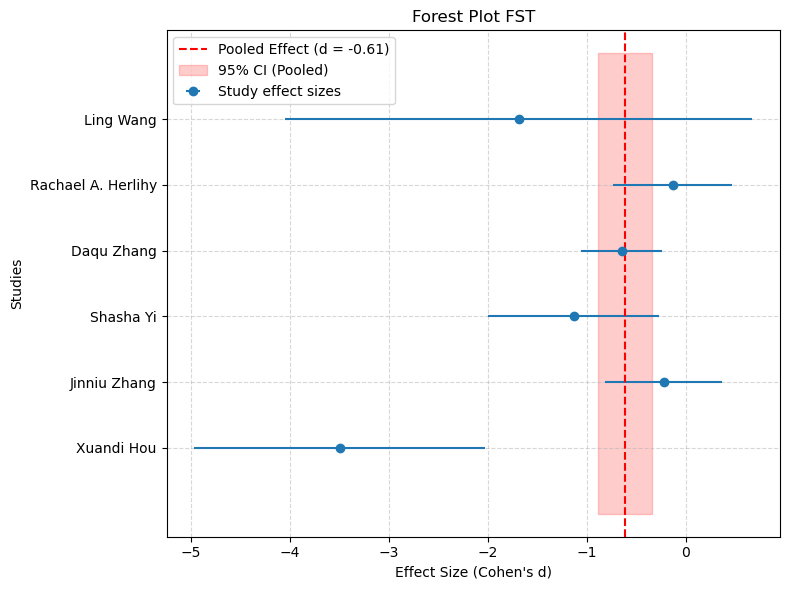

fixed effect meta results
{'pooled_d': np.float64(-0.6095288550955865), '95%_CI': (np.float64(-0.8811963702934003), np.float64(-0.3378613398977728)), 'heterogeneity_I2': np.float64(76.36851321579971)}
pooled d random effect -0.9128789240916859
pooled d CI random effect [ -1.5666051333335456 , -0.25915271484982627 ]


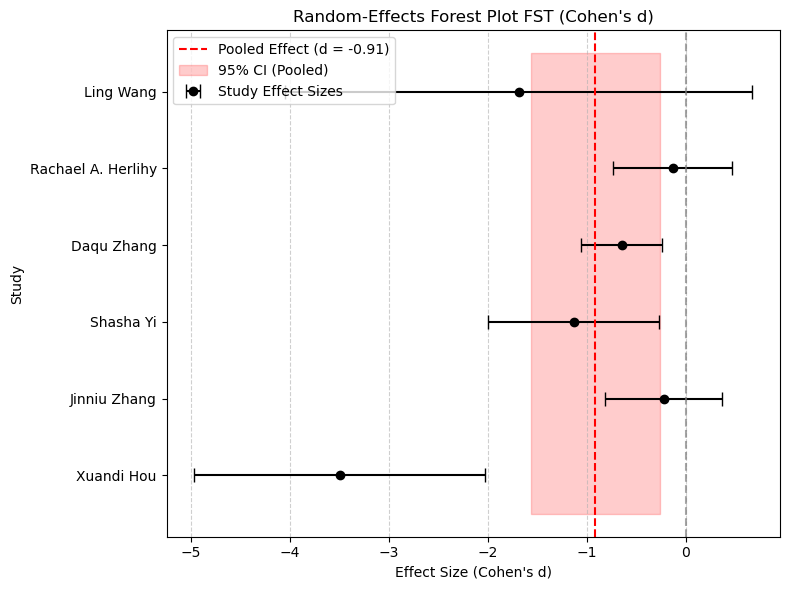

In [23]:
# calculate effect size for FST 
from scipy.stats import f
from scipy.stats import t
from math import sqrt
from scipy.stats import ncf
import numpy as np
# Jinniu Zhang
t_stat_200Hz = 2.691  # t-statistic for 200 Hz
p_value_200Hz = 0.05  # significance level
n1 = 7  # assumed sample size for each condition
n2 = 8  # assumed equal sample size
print('Jinniu Zhang')
# Cohen's d for 200 Hz
cohens_d_200Hz = t_stat_200Hz / np.sqrt(n1 + n2)
print(cohens_d_200Hz)
var_d_200Hz = (1 / n1) + (1 / n2) + (cohens_d_200Hz**2) / (2 * (n1 + n2))
cohens_d_285Hz = 0  # no effect
cohens_d_500Hz = 0  # no effect

# for 285 Hz and 500 Hz (based on pooled variance approximation)
var_d_285Hz = (1 / n1) + (1 / n2)
var_d_500Hz = (1 / n1) + (1 / n2)

# combine data for meta-analysis
effect_sizes = np.array([cohens_d_200Hz, cohens_d_285Hz, cohens_d_500Hz])
variances = np.array([var_d_200Hz, var_d_285Hz, var_d_500Hz])
weights = 1 / variances

# pooled effect size
pooled_d = np.sum(weights * effect_sizes) / np.sum(weights)
pooled_var = 1 / np.sum(weights)
print(pooled_d, pooled_var)

# (Daqu Zhang)
p_value = 0.221  # p-value from one-way ANOVA, from source data
k = 3  # number of groups
n_per_group = 16  # sample size per group
total_sample_size = k * n_per_group  # total sample size
df_effect = k - 1  # degrees of freedom for effect
df_error = total_sample_size - k  # degrees of freedom for error
# get f-statistic corresponding to p-value
F_stat = f.ppf(1 - p_value, df_effect, df_error)  # Inverse CDF to find F-stat for given p-value
print(F_stat)
# partial eta squared calculation
eta_squared = (F_stat * df_effect) / (F_stat * df_effect + df_error)
# convert eta-squared to Cohen's f
cohens_f = sqrt(eta_squared / (1 - eta_squared))
# convert Cohen's f to Cohen's d (for k=3 groups)
cohens_d = 2 * cohens_f * sqrt(k / (k - 1))

# Variance of Cohen's d
# # var_d = (4 * cohens_f**2) / total_sample_size
# var_d_treatment = (1 / n_per_group) + (1 / n_per_group) + (cohens_d**2) / (2 * (n_per_group + n_per_group))
# print('Daqu')
# print(cohens_d, var_d)

# Rachel Her study
F_treatment = 0.1676
df_effect_treatment = 1
df_error_treatment = 39
total_sample_size_treatment = 43
n1 = 22 # assumed
n2 = 21
eta_p2_treatment = F_treatment * df_effect_treatment / (F_treatment * df_effect_treatment + df_error_treatment)

alpha = 0.05
lower_nc_treatment = ncf.ppf(alpha / 2, df_effect_treatment, df_error_treatment, F_treatment * df_effect_treatment)
upper_nc_treatment = ncf.ppf(1 - alpha / 2, df_effect_treatment, df_error_treatment, F_treatment * df_effect_treatment)

lower_eta_p2_treatment = lower_nc_treatment / (lower_nc_treatment + total_sample_size_treatment - df_effect_treatment)
upper_eta_p2_treatment = upper_nc_treatment / (upper_nc_treatment + total_sample_size_treatment - df_effect_treatment)
lower_f_treatment = np.sqrt(lower_eta_p2_treatment / (1 - lower_eta_p2_treatment))
upper_f_treatment = np.sqrt(upper_eta_p2_treatment / (1 - upper_eta_p2_treatment))

#partial eta-squared to Cohen's f for effect size
cohens_f_treatment = np.sqrt(eta_p2_treatment / (1 - eta_p2_treatment))

# Variance of Cohen's d (using Cohen's f to Cohen's d formula for k=2 groups)
cohens_d_treatment = 2 * cohens_f_treatment  # For two groups
# var_d_treatment = (4 * cohens_f_treatment**2) / total_sample_size_treatment
var_d_treatment = (1 / n1) + (1 / n2) + (cohens_d_treatment**2) / (2 * (n1 + n2))
print('Rachel')
print(eta_p2_treatment, cohens_d_treatment, var_d_treatment, (lower_f_treatment, upper_f_treatment))

# ling wang
p_value = 0.003  # p-value for CRS vs. CRS+FUS
n1 = 14  # sample size for CRS group
n2 = 16  # sample size for CRS+FUS group
df_error = n1 + n2 - 2  # Degrees of freedom 

t_stat_obs = t.ppf(1 - p_value / 2, df_error)  
# get Cohen's d directly using t-statistic
cohens_d = t_stat_obs / np.sqrt((1 / n1) + (1 / n2))

# setimate var of Cohen's d
var_d = (1 / n1) + (1 / n2) + (cohens_d**2) / (2 * (n1 + n2))
# t_stat_obs, cohens_d, var_d

# using F sta
k = 3  
total_sample_size = 43
df_effect = k - 1  # Degrees of freedom for effect
# in the paper, they report F(2,42), but it should be 2, 40
df_error = total_sample_size - k  # Degrees of freedom for error
# F-statistic corresponding to p-value
F_stat = 9.473

eta_squared = (F_stat * df_effect) / (F_stat * df_effect + df_error)

cohens_f = sqrt(eta_squared / (1 - eta_squared))

# Convert Cohen's f to Cohen's d (for k=3 groups)
cohens_d = 2 * cohens_f * sqrt(k / (k - 1))

# Variance of Cohen's d
var_d_treatment = (1 / n1) + (1 / n2) + (cohens_d**2) / (2 * (n1 + n2))

print('Lingwang')
print(cohens_d, var_d)

# forest plot
import numpy as np
import matplotlib.pyplot as plt

# get Data from source data file
data = [
    {"study": "Xuandi Hou", "d": None, "var_d": None, "mean_control": 119.566, "sem_control": 3.344, "n_control": 9, 
     "mean_intervention": 89.501, "sem_intervention": 2.294, "n_intervention": 9},
    {"study": "Jinniu Zhang", "d": -0.2226, "var_d": 0.091},
    {"study": "Shasha Yi", "d": None, "var_d": None, "mean_control": 152.4, "sem_control": 9.31, "n_control": 12,
     "mean_intervention": 111, "sem_intervention": 11.7, "n_intervention": 12},
    {"study": "Daqu Zhang", "d": -0.645, "var_d": 0.04406},
    {"study": "Rachael A. Herlihy", "d": -0.1311, "var_d": 0.09327},
    {"study": "Ling Wang", "d": -1.6858, "var_d": 1.4483}
]

# cohen's d function
def calculate_d_from_means(mean_control, sem_control, n_control, mean_intervention, sem_intervention, n_intervention):
    sd_control = sem_control * np.sqrt(n_control)
    sd_intervention = sem_intervention * np.sqrt(n_intervention)
    pooled_sd = np.sqrt(((n_control - 1) * sd_control**2 + (n_intervention - 1) * sd_intervention**2) / (n_control + n_intervention - 2))
    d = (mean_intervention - mean_control) / pooled_sd
    var_d = (n_control + n_intervention) / (n_control * n_intervention) + d**2 / (2 * (n_control + n_intervention))
    return d, var_d

#  studies with missing d and var_d
for study in data:
    if study["d"] is None:
        d, var_d = calculate_d_from_means(
            study["mean_control"], study["sem_control"], study["n_control"],
            study["mean_intervention"], study["sem_intervention"], study["n_intervention"]
        )
        study["d"] = d
        study["var_d"] = var_d

# extract effect sizes and variances for meta-analysis
effect_sizes = np.array([study["d"] for study in data])
variances = np.array([study["var_d"] for study in data])
weights = 1 / variances

pooled_d = np.sum(weights * effect_sizes) / np.sum(weights)
pooled_var = 1 / np.sum(weights)

ci_lower = pooled_d - 1.96 * np.sqrt(pooled_var)
ci_upper = pooled_d + 1.96 * np.sqrt(pooled_var)

q = np.sum(weights * (effect_sizes - pooled_d)**2)
df = len(data) - 1
i2 = max(0, (q - df) / q) * 100

meta_results = {
    "pooled_d": pooled_d,
    "95%_CI": (ci_lower, ci_upper),
    "heterogeneity_I2": i2
}

# Forest plot
fig=plt.figure(figsize=(8, 6))
y_pos = np.arange(len(data)) + 1

plt.errorbar(effect_sizes, y_pos, xerr=1.96 * np.sqrt(variances), fmt='o', label='Study effect sizes')

plt.axvline(pooled_d, color='red', linestyle='--', label=f"Pooled Effect (d = {pooled_d:.2f})")
plt.fill_betweenx([0, len(data) + 1], 
                  pooled_d - 1.96 * np.sqrt(pooled_var), 
                  pooled_d + 1.96 * np.sqrt(pooled_var), 
                  color='red', alpha=0.2, label='95% CI (Pooled)')

# Formatting
plt.yticks(y_pos, [study["study"] for study in data])
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Studies')
plt.title('Forest Plot FST')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# fig.savefig('fst_forestplot.pdf')

plt.show()
print('fixed effect meta results')
print(meta_results)
## random
def random_effects_meta(effects, variances):
    k = len(effects)
    weights_fixed = 1 / variances
    pooled_fixed = np.sum(weights_fixed * effects) / np.sum(weights_fixed)
    Q = np.sum(weights_fixed * (effects - pooled_fixed) ** 2)
    df = k - 1
    tau2 = max(0, (Q - df) / (np.sum(weights_fixed) - np.sum(weights_fixed**2) / np.sum(weights_fixed)))
    
    weights_random = 1 / (variances + tau2)
    pooled_d = np.sum(weights_random * effects) / np.sum(weights_random)
    pooled_var = 1 / np.sum(weights_random)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    return pooled_d, ci_lower, ci_upper, tau2, Q, df

# Compute random effects results
rand_d, rand_ci_lo, rand_ci_hi, tau2, Q, df = random_effects_meta(effect_sizes, variances)

# Build DataFrame for plotting
df_plot = pd.DataFrame({
    "study": pd.DataFrame(data)['study'],
    "effect": effect_sizes,
    "var": variances,
    "se": np.sqrt(variances),
})
df_plot["ci_lower"] = df_plot["effect"] - 1.96 * df_plot["se"]
df_plot["ci_upper"] = df_plot["effect"] + 1.96 * df_plot["se"]
print(f'pooled d random effect {rand_d}')
print(f'pooled d CI random effect [ {rand_ci_lo} , {rand_ci_hi} ]')
# print(f'pooled d random effect {rand_d}')

# Forest plot function
def refined_forest_plot(data, effect_col, ci_lower_col, ci_upper_col, pooled_d, pooled_ci_lower, pooled_ci_upper, title, filename):
    plt.figure(figsize=(8, 6))
    y_pos = range(len(data))
    plt.errorbar(data[effect_col], y_pos, 
                 xerr=[data[effect_col] - data[ci_lower_col], data[ci_upper_col] - data[effect_col]], 
                 fmt='o', color='black', label='Study Effect Sizes', capsize=5)
    
    plt.axvline(pooled_d, color='red', linestyle='--', label=f'Pooled Effect (d = {pooled_d:.2f})')
    plt.fill_betweenx(
        [-0.5, len(data) - 0.5],
        pooled_ci_lower, pooled_ci_upper,
        color='red', alpha=0.2, label='95% CI (Pooled)'
    )
    
    plt.yticks(y_pos, data["study"])
    plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("Study")
    plt.legend(loc="upper left")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    # for adding the figure to the paper
    plt.savefig(filename)
    plt.show()

# Call the plot function
refined_forest_plot(
    df_plot,
    "effect",
    "ci_lower",
    "ci_upper",
    rand_d,
    rand_ci_lo,
    rand_ci_hi,
    "Random-Effects Forest Plot FST (Cohen's d)", 'FST_random_effect_meta.pdf'
)

## TST

-3.3466673981939095 0.5333384076148331
3.046928775050517 8.325794438754196 1.289242788701743
6.377
1.3661767910450842 1.289242788701743


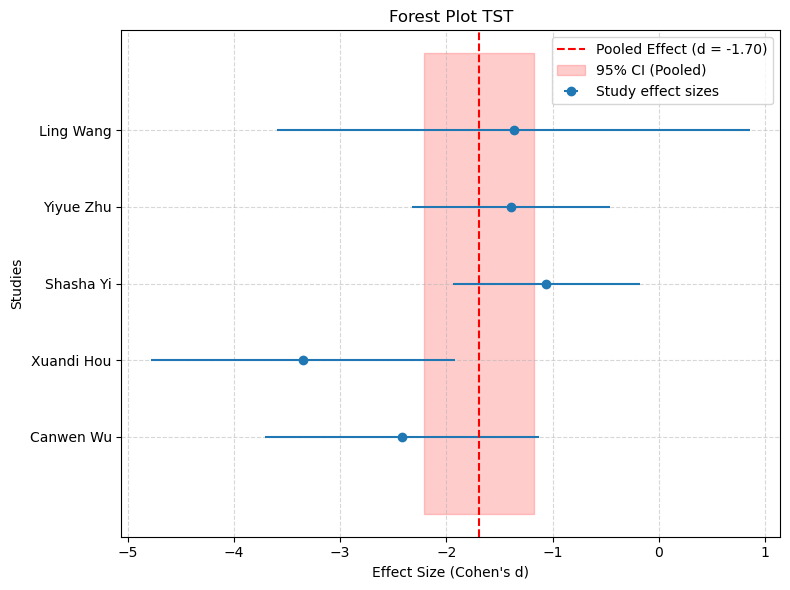

fixed effect
{'pooled_d': np.float64(-1.6967362212436088), '95%_CI': (np.float64(-2.2140774413581066), np.float64(-1.179395001129111)), 'heterogeneity_I2': np.float64(54.75914484822594)}
pooled d random effect -1.8510683949332747
pooled d CI random effect [ -2.6724232096407747 , -1.0297135802257746 ]


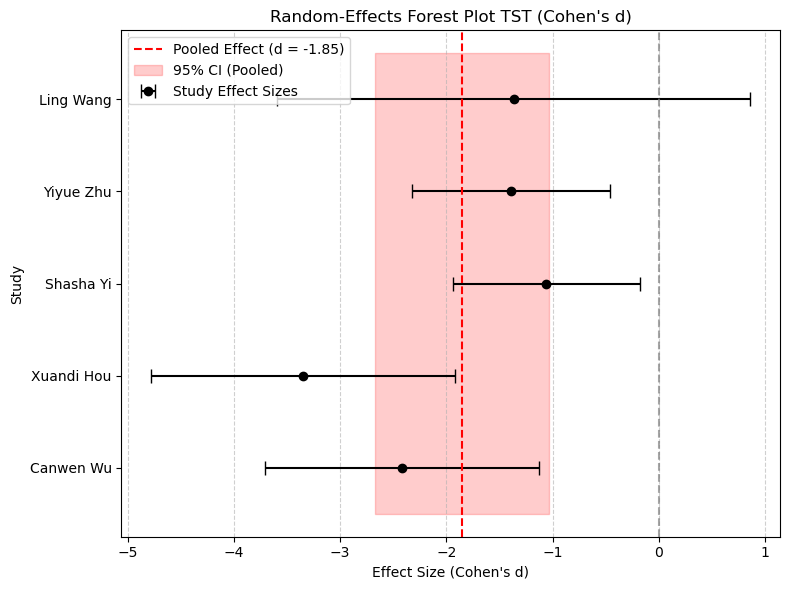

In [24]:
# Xuandi Hou
# raw data for control and intervention groups from Hou's paper
control_group = [130.17, 114.67, 121.45, 119.78, 122.43, 128.65, 117.57, 123.36, 118.43]
intervention_group = [49.13, 54.06, 85.17, 66.55, 63.82, 47.47, 105.35, 95.43, 77.24]

def calculate_effect_size_and_variance(control, intervention):
    mean_control = np.mean(control)
    mean_intervention = np.mean(intervention)
    
    n_control = len(control)
    n_intervention = len(intervention)
    sd_control = np.std(control, ddof=1)
    sd_intervention = np.std(intervention, ddof=1)
    pooled_sd = np.sqrt(((n_control - 1) * sd_control**2 + (n_intervention - 1) * sd_intervention**2) / (n_control + n_intervention - 2))
    
    d = (mean_intervention - mean_control) / pooled_sd
    
    var_d = (n_control + n_intervention) / (n_control * n_intervention) + d**2 / (2 * (n_control + n_intervention))
    
    return d, var_d

effect_size, variance = calculate_effect_size_and_variance(control_group, intervention_group)
print(effect_size, variance)

# ling wang
p_value = 0.005  # p-value for CRS vs. CRS+FUS
n1 = 14  # n for CRS group
n2 = 16  # n for CRS+FUS group
df_error = n1 + n2 - 2  # degree of freedom for the comparison

t_stat_obs = t.ppf(1 - p_value / 2, df_error)  # two-tailed t-test
cohens_d = t_stat_obs / np.sqrt((1 / n1) + (1 / n2))

var_d = (1 / n1) + (1 / n2) + (cohens_d**2) / (2 * (n1 + n2))
print(t_stat_obs, cohens_d, var_d)

# using F sta
k = 3  
total_sample_size = 44
df_effect = k - 1  # Degrees of freedom for effect
df_error = total_sample_size - k  # Degrees of freedom for error
# F-statistic corresponding to p-value
F_stat = 6.377
print(F_stat)
n1 = 14
n2 = 16
# Partial eta squared calculation
eta_squared = (F_stat * df_effect) / (F_stat * df_effect + df_error)

# convert eta-squared to Cohen's f
cohens_f = sqrt(eta_squared / (1 - eta_squared))
# convert Cohen's f to Cohen's d (for k=3 groups)
cohens_d = 2 * cohens_f * sqrt(k / (k - 1))
var_d_treatment = (1 / n1) + (1 / n2) + (cohens_d**2) / (2 * (n1 + n2))

print(cohens_d, var_d)

import numpy as np
import matplotlib.pyplot as plt

# Data from the source data
data = [
    {"study": "Canwen Wu", "mean_control": 125.3, "sem_control": 9.36, "n_control": 8,
     "mean_intervention": 66.38, "sem_intervention": 7.77, "n_intervention": 8},
    {"study": "Xuandi Hou", "d": -3.347, "var_d": 0.533},
    {"study": "Shasha Yi", "mean_control": 165.80, "sem_control": 7.24, "n_control": 10,
     "mean_intervention": 141.5, "sem_intervention": 6.39, "n_intervention": 13},
    {"study": "Yiyue Zhu", "mean_control": 121.3, "sem_control": 12.58, "n_control": 11,
     "mean_intervention": 72.09, "sem_intervention": 8.254, "n_intervention": 11},
    {"study": "Ling Wang", "d": -1.36617, "var_d": 1.2892}
]

def calculate_d_from_means(mean_control, sem_control, n_control, mean_intervention, sem_intervention, n_intervention):
    sd_control = sem_control * np.sqrt(n_control)
    sd_intervention = sem_intervention * np.sqrt(n_intervention)
    pooled_sd = np.sqrt(((n_control - 1) * sd_control**2 + (n_intervention - 1) * sd_intervention**2) / (n_control + n_intervention - 2))
    d = (mean_intervention - mean_control) / pooled_sd
    var_d = (n_control + n_intervention) / (n_control * n_intervention) + d**2 / (2 * (n_control + n_intervention))
    return d, var_d

for study in data:
    if "mean_control" in study:
        d, var_d = calculate_d_from_means(
            study["mean_control"], study["sem_control"], study["n_control"],
            study["mean_intervention"], study["sem_intervention"], study["n_intervention"]
        )
        study["d"] = d
        study["var_d"] = var_d

effect_sizes = np.array([study["d"] for study in data])
variances = np.array([study["var_d"] for study in data])
weights = 1 / variances

pooled_d = np.sum(weights * effect_sizes) / np.sum(weights)
pooled_var = 1 / np.sum(weights)

ci_lower = pooled_d - 1.96 * np.sqrt(pooled_var)
ci_upper = pooled_d + 1.96 * np.sqrt(pooled_var)

q = np.sum(weights * (effect_sizes - pooled_d)**2)
df = len(data) - 1
i2 = max(0, (q - df) / q) * 100

meta_results = {
    "pooled_d": pooled_d,
    "95%_CI": (ci_lower, ci_upper),
    "heterogeneity_I2": i2
}

fig=plt.figure(figsize=(8, 6))
y_pos = np.arange(len(data)) + 1

plt.errorbar(effect_sizes, y_pos, xerr=1.96 * np.sqrt(variances), fmt='o', label='Study effect sizes')

#  pooled effect size
plt.axvline(pooled_d, color='red', linestyle='--', label=f"Pooled Effect (d = {pooled_d:.2f})")
plt.fill_betweenx([0, len(data) + 1], 
                  pooled_d - 1.96 * np.sqrt(pooled_var), 
                  pooled_d + 1.96 * np.sqrt(pooled_var), 
                  color='red', alpha=0.2, label='95% CI (Pooled)')

plt.yticks(y_pos, [study["study"] for study in data])
plt.xlabel('Effect Size (Cohen\'s d)')
plt.ylabel('Studies')
plt.title('Forest Plot TST')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# fig.savefig('tst_forestplot.pdf')

plt.show()
print('fixed effect')
print(meta_results)

## random
def random_effects_meta(effects, variances):
    k = len(effects)
    weights_fixed = 1 / variances
    pooled_fixed = np.sum(weights_fixed * effects) / np.sum(weights_fixed)
    Q = np.sum(weights_fixed * (effects - pooled_fixed) ** 2)
    df = k - 1
    tau2 = max(0, (Q - df) / (np.sum(weights_fixed) - np.sum(weights_fixed**2) / np.sum(weights_fixed)))
    
    weights_random = 1 / (variances + tau2)
    pooled_d = np.sum(weights_random * effects) / np.sum(weights_random)
    pooled_var = 1 / np.sum(weights_random)
    pooled_se = np.sqrt(pooled_var)
    ci_lower = pooled_d - 1.96 * pooled_se
    ci_upper = pooled_d + 1.96 * pooled_se
    return pooled_d, ci_lower, ci_upper, tau2, Q, df

# Compute random effects results
rand_d, rand_ci_lo, rand_ci_hi, tau2, Q, df = random_effects_meta(effect_sizes, variances)

# Build DataFrame for plotting
df_plot = pd.DataFrame({
    "study": pd.DataFrame(data)['study'],
    "effect": effect_sizes,
    "var": variances,
    "se": np.sqrt(variances),
})
df_plot["ci_lower"] = df_plot["effect"] - 1.96 * df_plot["se"]
df_plot["ci_upper"] = df_plot["effect"] + 1.96 * df_plot["se"]
print(f'pooled d random effect {rand_d}')
print(f'pooled d CI random effect [ {rand_ci_lo} , {rand_ci_hi} ]')
# print(f'pooled d random effect {rand_d}')

# Forest plot function
def refined_forest_plot(data, effect_col, ci_lower_col, ci_upper_col, pooled_d, pooled_ci_lower, pooled_ci_upper, title, filename):
    plt.figure(figsize=(8, 6))
    y_pos = range(len(data))
    plt.errorbar(data[effect_col], y_pos, 
                 xerr=[data[effect_col] - data[ci_lower_col], data[ci_upper_col] - data[effect_col]], 
                 fmt='o', color='black', label='Study Effect Sizes', capsize=5)
    
    plt.axvline(pooled_d, color='red', linestyle='--', label=f'Pooled Effect (d = {pooled_d:.2f})')
    plt.fill_betweenx(
        [-0.5, len(data) - 0.5],
        pooled_ci_lower, pooled_ci_upper,
        color='red', alpha=0.2, label='95% CI (Pooled)'
    )
    
    plt.yticks(y_pos, data["study"])
    plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("Study")
    plt.legend(loc="upper left")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    # for adding the figure to the paper
    plt.savefig(filename)
    plt.show()

# Call the plot function
refined_forest_plot(
    df_plot,
    "effect",
    "ci_lower",
    "ci_upper",
    rand_d,
    rand_ci_lo,
    rand_ci_hi,
    "Random-Effects Forest Plot TST (Cohen's d)", 'TST_random_effect_meta.pdf'
)

## additional script for calculating statistics

In [59]:
import numpy as np
7.24/np.sqrt(15)

np.float64(1.8693599617694465)